# Prepare Geodesic distances as regressor

This notebook computes two types of geometric regressors:<br>
(A) **Geodesic distances from each LH vertex to landmarks** (parcels of a group-level parcellation, superimposed on the individual geometry, i.e. the cortical surface mesh)<br>
(B) **PCA components of the vertex-to-vertex geodesic distance matrix** (+ compute and align them to the group level distance matrix)
<br>
For both, LH Distances are computed after removal of the medial wall.<br>

**Inputs**

Indiviudal Brain Surfaces (aligned to FSLR32k)<br>
`{subj}/T1w/fsaverage_LR32k/{subj}.L.midthickness_MSMAll.32k_fs_LR.surf.gii`

A Parcellation (for A)<br>
`/home/users/robert.scholz2/res/atlases/lausanne18_cammoun12/fsLR32k/lausanne08.sc4.fslr32k.LR.dlabel.nii`

**Outputs**

HCP Individual Subject VxV Geodesic distances (vertex to landmarks)<br>
`/scratch/users/robert.scholz2/acc_dists/all_dists_254_full_unrelated.centroid_dist.raw.npy`

HCP Group Average VxV Geodesic distance matrix (for B)<br>
`data/group_distance_components.pca200c.npy`

HCP Individual Subject VxV Geodesic distance matrix-PCA-Components (for B)<br>
`/scratch/users/robert.scholz2/acc_dists/all_dists_254_full_unrelated.29x200.grPCA_aligned.L.np`

<br>

In [1]:
import os
import nibabel as nib
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np

from importlib import reload 
import lib.aws_tools
reload(lib.aws_tools)
from lib.aws_tools import download_aws_file, exists_locally_or_on_aws
f= lambda str: eval("f'" + f"{str}" + "'")

import hcp_utils as hcp

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
nativ_32k_surf      = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness_MSMAll.32k_fs_LR.surf.gii"
nativ_29k_surf_noMW = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness_MSMAll.29k.noMW.surf.gii"
H="L"

# Geodesic distances from vertex to landmarks (parcellation)

## Removal of the medial wall

In [5]:
## remove medial wall from surface mesh
def triangles_keep_cortex(triangles, cortex):
    """Remove triangles with nodes not contained in the cortex label array"""
    # for or each face/triangle keep only those that only contain nodes within the list of cortex nodes
    input_shape = triangles.shape
    triangle_is_in_cortex = np.all(np.reshape(np.in1d(triangles.ravel(), cortex), input_shape), axis=1)
    cortex_triangles_old = np.array(triangles[triangle_is_in_cortex], dtype=np.int32)
    # reassign node index before outputting triangles
    new_index = np.digitize(cortex_triangles_old.ravel(), cortex, right=True)
    cortex_triangles = np.array(np.arange(len(cortex))[new_index].reshape(cortex_triangles_old.shape), dtype=np.int32)
    return cortex_triangles


In [158]:
left_cortex_indices_from32k=hcp.vertex_info['gray' + H.lower()];
local_hcp_dir ="/scratch/users/robert.scholz2/HCP_1200/"

t_32k_surf = nativ_32k_surf
t_29k_surf_noMW = nativ_29k_surf_noMW 

for n, subj in tqdm(enumerate(full_subjs)): 
    globals()["subj"] = subj; 
    if os.path.exists(local_hcp_dir + f(t_29k_surf_noMW)): continue;
    
    # load the native surface mesh
    pial_left_gii = nib.load(local_hcp_dir + f(t_32k_surf))
    pial_left_gii_points = pial_left_gii.darrays[0].data # NIFTI_INTENT_POINTSET
    pial_left_gii_triang = pial_left_gii.darrays[1].data # NIFTI_INTENT_TRIANGLE
    
    # remove the medial wall vertcies and triangles
    pial_left_gii_points_29k = pial_left_gii_points[left_cortex_indices_from32k,:]
    pial_left_gii_triang_29k = triangles_keep_cortex(pial_left_gii_triang, left_cortex_indices_from32k)
    
    nlgii=pial_left_gii; # copy.deepcopy(pial_left_gii)
    nlgii.darrays[0].data = pial_left_gii_points_29k
    nlgii.darrays[1].data = pial_left_gii_triang_29k
    nlgii.darrays[0].dims = pial_left_gii_points_29k.shape
    nlgii.darrays[1].dims = pial_left_gii_triang_29k.shape
    
    # save the surface meshes with medial wall removed
    # as "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness_MSMAll.29k.noMW.surf.gii"
    nib.save(nlgii, local_hcp_dir + f(t_29k_surf_noMW)) 
    if n< 5: print("saved: ", local_hcp_dir + f(t_29k_surf_noMW))
    

print("\n\nDone.")

254it [00:00, 1474.78it/s]



Done.


## Distance calculation [ext]

As this calculation requires access to HCP workbench (through singularity) which is not accessible in jupyter, instead I saved the code as python-file and ran it directly through the cli 

In [150]:
%%writefile make_surface_dist_mats_29x29b.py

import os
import numpy as np
import subprocess as sp
f= lambda str: eval("f'" + f"{str}" + "'")
from tqdm import tqdm
import nibabel as nib

import hcp_utils as hcp


full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);

H="L"
t_scon_29x29  = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness.MSMAll.native.surf.dconn.nii"
t_29k_surf_noMW = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness_MSMAll.29k.noMW.surf.gii"

local_hcp_dir ="/scratch/users/robert.scholz2/HCP_1200/"
wb_geoAll2all   = "singularity exec -B /local/jobs -B /scratch/users/robert.scholz2 -B /home/mpg02/MLSC/robert.scholz2/bigdata --env FS_LICENSE=/home/mpg02/MLSC/robert.scholz2/bigdata/container/frmiprep_fs_license.txt /home/mpg02/MLSC/robert.scholz2/bigdata/container/fmriprep.simg wb_command -surface-geodesic-distance-all-to-all {input} {outp}"

from lib.dist_tools import load_cifti_parcellation, get_region_based_conn

cifti2 = "/home/users/robert.scholz2/res/atlases/lausanne18_cammoun12/fsLR32k/lausanne08.sc4.fslr32k.LR.dlabel.nii";
label_data, label_dict = load_cifti_parcellation(cifti2, structure="left_cortex", verbose=0)
label_list = label_data[hcp.vertex_info['grayl']]
regions = np.unique(label_list)
len(regions), len(label_list), regions[:4], len(label_dict), list(label_dict.keys())[:5]

parcell="cam_laus_08s4"
t_scon_29xGEN  = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness.MSMAll.native.surf.29x{parcell}.{dist_type}.npy"

for n, subj in tqdm(enumerate(full_subjs), total=len(full_subjs)): 
    #### do 29k x 29k surface connectivtiy mat
    
    dist_type = "centroid_dist"
    if os.path.exists(local_hcp_dir + f(t_scon_29xGEN)):
        continue;

    globals()["input"]  = local_hcp_dir + f(t_29k_surf_noMW); 
    out29kmat = local_hcp_dir +f(t_scon_29x29);
    globals()["outp"]   = out29kmat;
    #wb_geoAll2all    = "wb_command -surface-geodesic-distance-all-to-all {input} {outp}"
    
    if not(os.path.exists(out29kmat)):
      print("Create: ", f(t_scon_29x29), flush=1)
      cmd = f(wb_geoAll2all);
      res = sp.run(cmd, shell=True, check=True,  capture_output=True);
      #print(res.stdout.decode('utf-8'))
    
    
    scm = nib.load(out29kmat)
    scmfd = scm.get_fdata()
    scout = get_region_based_conn(scmfd, label_list, regions).astype(np.float32)
    for i, dist_type in enumerate(["min_dist","mean_dist", "centroid_dist"]):
      np.save( local_hcp_dir + f(t_scon_29xGEN), scout[i]) 
      print("Saved: ", f(t_scon_29xGEN))
      
    os.remove(out29kmat)
    print("Deleted: ", out29kmat)
    
      

Overwriting make_surface_dist_mats_29x29b.py


In [45]:
!ls -ash /scratch/users/robert.scholz2/HCP_1200/100206/T1w/fsaverage_LR32k/100206.L.midthickness.MSMAll.native.surf.dconn.nii

3.3G /scratch/users/robert.scholz2/HCP_1200/100206/T1w/fsaverage_LR32k/100206.L.midthickness.MSMAll.native.surf.dconn.nii


In [94]:
!ls -ash /scratch/users/robert.scholz2/HCP_1200/100610/T1w/fsaverage_LR32k/100610.L.midthickness.MSMAll.native.surf.29xcam_laus_08s4.centroid_dist.npy

26M /scratch/users/robert.scholz2/HCP_1200/100610/T1w/fsaverage_LR32k/100610.L.midthickness.MSMAll.native.surf.29xcam_laus_08s4.centroid_dist.npy


## Save all distances to a single file

In [4]:
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
len(full_subjs), full_subjs[:4]

(254, array(['100206', '100610', '101006', '101309'], dtype='<U21'))

In [ ]:
def load_subj_dist_file(subj)
  file_pattern= '%s/T1w/fsaverage_LR32k/%s.L.midthickness.MSMAll.native.surf.29xcam_laus_08s4.centroid_dist.npy';
  dist_path = self.dist_file_pattern % (subj,subj) 
  return np.load(os.path.join("/scratch/users/robert.scholz2/HCP_1200/", dist_path))

data = {subj: self.get_subj(subj)[idx].astype(dtype) for subj in tqdm(full_subjs)}
fn = "/scratch/users/robert.scholz2/acc_dists/all_dists_254_full_unrelated.centroid_dist.raw.npy"
np.save(fn, data);

# PCA on distance matrix (vertex-vertex)

## Distance calculation using HCP workbench

In [ ]:
%%writefile make_surface_dist_mats_29x29b_pca.py

import os
import numpy as np
import subprocess as sp
f= lambda str: eval("f'" + f"{str}" + "'")
from tqdm import tqdm
import nibabel as nib

from sklearn.decomposition import PCA
#from brainspace.gradient.alignment import ProcrustesAlignment

#group_comps = np.load("data/group_components.dist200c.npy")
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);

H="L"
t_scon_29x29  = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness.MSMAll.native.surf.dconn.nii"
t_29k_surf_noMW = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness_MSMAll.29k.noMW.surf.gii"

local_hcp_dir ="/scratch/users/robert.scholz2/HCP_1200/"
wb_geoAll2all   = "singularity exec -B /local/jobs -B /scratch/users/robert.scholz2 -B /home/mpg02/MLSC/robert.scholz2/bigdata --env FS_LICENSE=/home/mpg02/MLSC/robert.scholz2/bigdata/container/frmiprep_fs_license.txt /home/mpg02/MLSC/robert.scholz2/bigdata/container/fmriprep.simg wb_command -surface-geodesic-distance-all-to-all {input} {outp}"

parcell="cam_laus_08s4"
t_scon_29x200  = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness.MSMAll.native.surf.29x200.rawPCA.npy"

last_group_mat = f"/scratch/users/robert.scholz2/nixxx.npy"
grmat = None

expl_vars_indv = np.zeros((len(full_subjs), 200))

for n, subj in tqdm(enumerate(full_subjs), total=len(full_subjs)): 
    #### do 29k x 29k surface connectivtiy mat
    
    final_subj_out_dmat = local_hcp_dir + f(t_scon_29x200);
    if os.path.exists(final_subj_out_dmat):
      continue;
      #print("Removed preexisting: ", final_subj_out_dmat)  
      #os.remove(final_subj_out_dmat)
    
    globals()["input"]  = local_hcp_dir + f(t_29k_surf_noMW); 
    out29kmat = local_hcp_dir +f(t_scon_29x29);
    globals()["outp"]   = out29kmat;
    #wb_geoAll2all    = "wb_command -surface-geodesic-distance-all-to-all {input} {outp}"
    
    if not(os.path.exists(out29kmat)):
      print("Create: ", f(t_scon_29x29), flush=1)
      cmd = f(wb_geoAll2all);
      res = sp.run(cmd, shell=True, check=True,  capture_output=True);
      #print(res.stdout.decode('utf-8'))
    
    
    scm = nib.load(out29kmat)
    scmfd = scm.get_fdata()
    
    pca_indv = PCA(n_components=200)
    indiv_comps = pca_indv.fit_transform(scmfd)
    #indiv_comps.shape
    np.save( final_subj_out_dmat, indiv_comps.astype(np.float32))
    print("Saved:", final_subj_out_dmat) 
    expl_vars_indv[i,:] = pca_indv.explained_variance_ratio_
    np.save("indv_explained_variance.dist.npy", [n, full_subjs, expl_vars_indv], allow_pickle=1)
    
    # Unelegant calculation of the group connectivity matrix
    last_group_mat = f"/scratch/users/robert.scholz2/gr_dist_mat_{n-1}.npy"
    if os.path.exists(last_group_mat):
      if grmat is None: 
        grmat = np.load(last_group_mat)
      
      grmat = grmat + scmfd
      os.remove(last_group_mat)
    else:
      grmat = scmfd;
    
    last_group_mat = f"/scratch/users/robert.scholz2/gr_dist_mat_{n}.npy"
    np.save(last_group_mat, grmat.astype(np.float32))
    print("Saved:", last_group_mat)
    
    os.remove(out29kmat)
    print("Deleted: ", out29kmat)


count= len(full_subjs)
last_group_mat = f"/scratch/users/robert.scholz2/gr_dist_mat_{count-1}.npy"
grmat = np.load(last_group_mat)
mean_dmat_f = f"/scratch/users/robert.scholz2/hcp/mean_distance_mat_{count}subjs.npy"
mean_mat = grmat/len(full_subjs)
np.save(mean_dmat_f, mean_mat.astype(np.float32))

Overwriting make_surface_dist_mats_29x29b_pca.py


In [6]:
# saving the final group mean distance matrix, to allow later alignment
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
count = len(full_subjs)
last_group_mat = f"/scratch/users/robert.scholz2/gr_dist_mat_{count-1}.npy"
print(last_group_mat)
grmat = np.load(last_group_mat)
print(grmat.shape, grmat.mean())
mean_dmat_f = f"/scratch/users/robert.scholz2/hcp/mean_distance_mat_{count}subjs.npy"
mean_mat = grmat/count
#np.save(mean_dmat_f, mean_mat.astype(np.float32))

# saved as: /scratch/users/robert.scholz2/hcp/mean_distance_mat_254subjs.npy

/scratch/users/robert.scholz2/gr_dist_mat_253.npy
(29696, 29696) 31098.81


## Decomposition of the group distance matrix

In [4]:
mean_mat = np.load("/scratch/users/robert.scholz2/hcp/mean_distance_mat_254subjs.npy")
print(mean_mat.shape)

(29696, 29696)


In [6]:
from sklearn.decomposition import PCA
pca1 = PCA(n_components=200)
group_comps = pca1.fit_transform(mean_mat) #pca1.fit(ca(cmat))
print(group_comps.shape)
np.save("data/group_distance_components.pca200c.npy", group_comps)

(29696, 200)


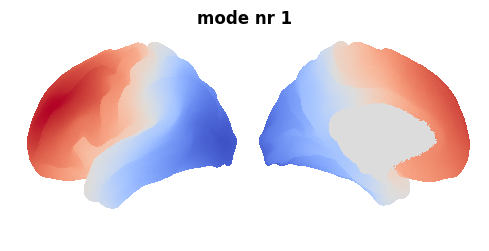

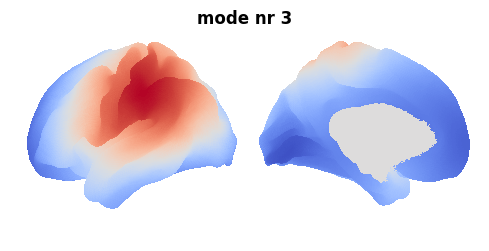

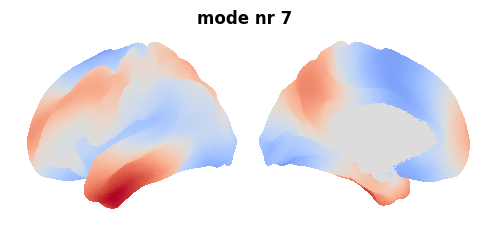

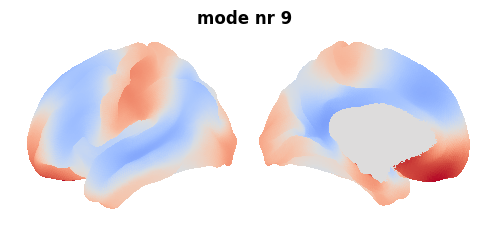

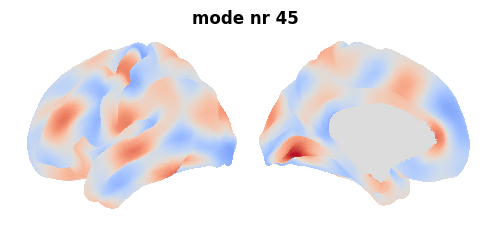

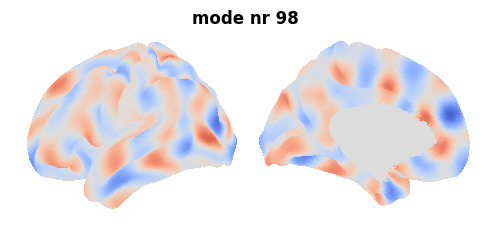

In [22]:
from lib.plotting import plot_29k
# different numbering to compare with SEmodes
for mn in [1,3, 7, 9,  45, 98]:
  plot_29k(group_comps[:, mn-1], colorbar=False, title=f"mode nr {mn}")

## Alignment of subjects

In [ ]:
from brainspace.gradient.alignment import ProcrustesAlignment

# loading of the group components (if needed)
group_comps= np.load("data/group_distance_components.pca200c.npy") 
local_hcp_dir ="/scratch/users/robert.scholz2/HCP_1200/"

In [ ]:
## Single Subject example

# loading of the indiviudal subject
subj = "131217"; H="L";
t_scon_29x200  = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness.MSMAll.native.surf.29x200.rawPCA.npy"
final_subj_out_dmat = local_hcp_dir + f(t_scon_29x200);
print(final_subj_out_dmat)
indiv_comps = np.load(final_subj_out_dmat)
print(indiv_comps.shape)

# Alignment using procrustes
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
indiv_comps_aligned = alignment.fit([indiv_comps], group_comps).aligned_[0]
indiv_comps_aligned.shape

In [12]:
# Alignment for all subjects

full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
# alternative: indiv_comps # subject 131217; idx=31
target_comps = group_comps 

t_scon_29x200  = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness.MSMAll.native.surf.29x200.rawPCA.npy"
acc_distance_data = {}

for n, subj in tqdm(enumerate(full_subjs), total=len(full_subjs)): 
  final_subj_out_dmat = local_hcp_dir + f(t_scon_29x200);
  indiv_comps = np.load(final_subj_out_dmat)
  indiv_comps_aligned = alignment.fit([indiv_comps], target_comps).aligned_[0]
  acc_distance_data[subj] = indiv_comps_aligned


100%|██████████| 254/254 [05:08<00:00,  1.22s/it]


In [27]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_dists_254_full_unrelated.29x200.grPCA_aligned.L.npy"
#np.save(fn, acc_distance_data)
!ls -ash {fn}

5.7G /scratch/users/robert.scholz2/acc_dists/all_dists_254_full_unrelated.29x200.grPCA_aligned.L.npy


# [Unrelated] Correlate subjects SE_modes with distances 

In [8]:
subj = '100206'
local_hcp_dir ="/scratch/users/robert.scholz2/HCP_1200/"
t_scon_29x200  = "{subj}/T1w/fsaverage_LR32k/{subj}.{H}.midthickness.MSMAll.native.surf.29x200.rawPCA.npy"
indiv_comps = np.load( local_hcp_dir + f(t_scon_29x200))
indiv_comps.shape, subj

((29696, 200), '100206')

In [9]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.unaligned.npy"
semodes = np.load(fn, allow_pickle=1).item()
sem = semodes[subj]
sem.shape

(29696, 200)

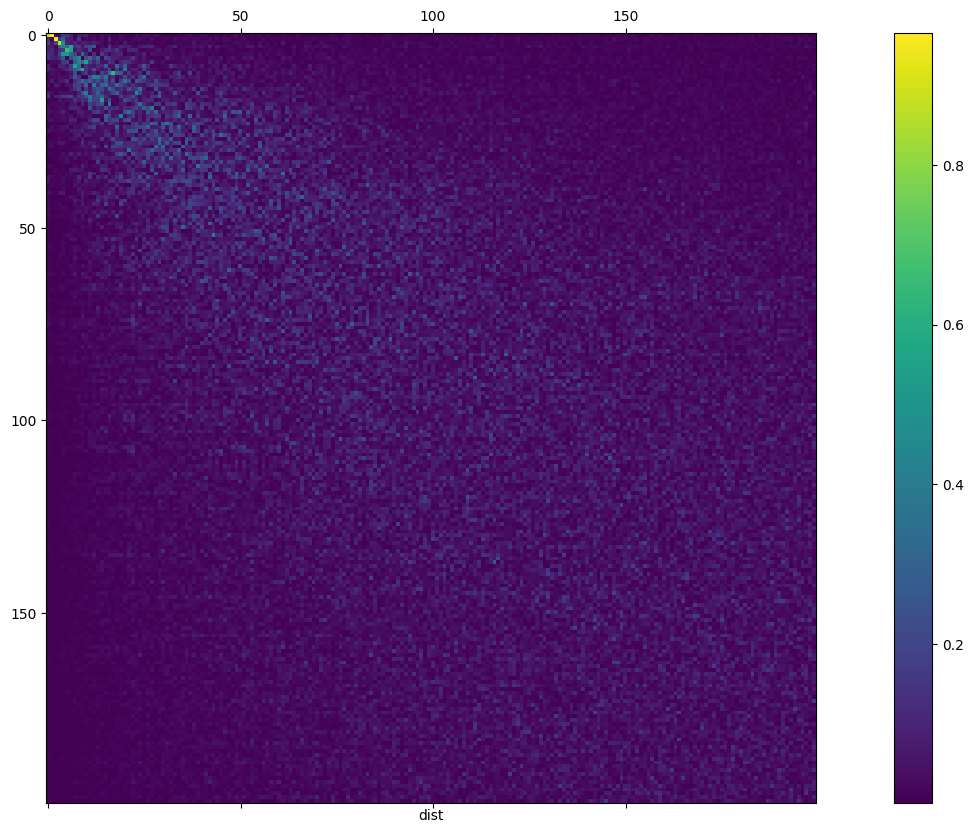

In [10]:
from matplotlib import pyplot as plt
cf = np.corrcoef(indiv_comps.T, sem.T)[:200,200:]

ax = plt.figure(figsize=(20,10)).gca()
im = ax.matshow(np.absolute(cf)); plt.colorbar(im); plt.xlabel("dist");

In [11]:
from brainspace.gradient.alignment import ProcrustesAlignment
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
sem_a = alignment.fit([sem], indiv_comps).aligned_[0]

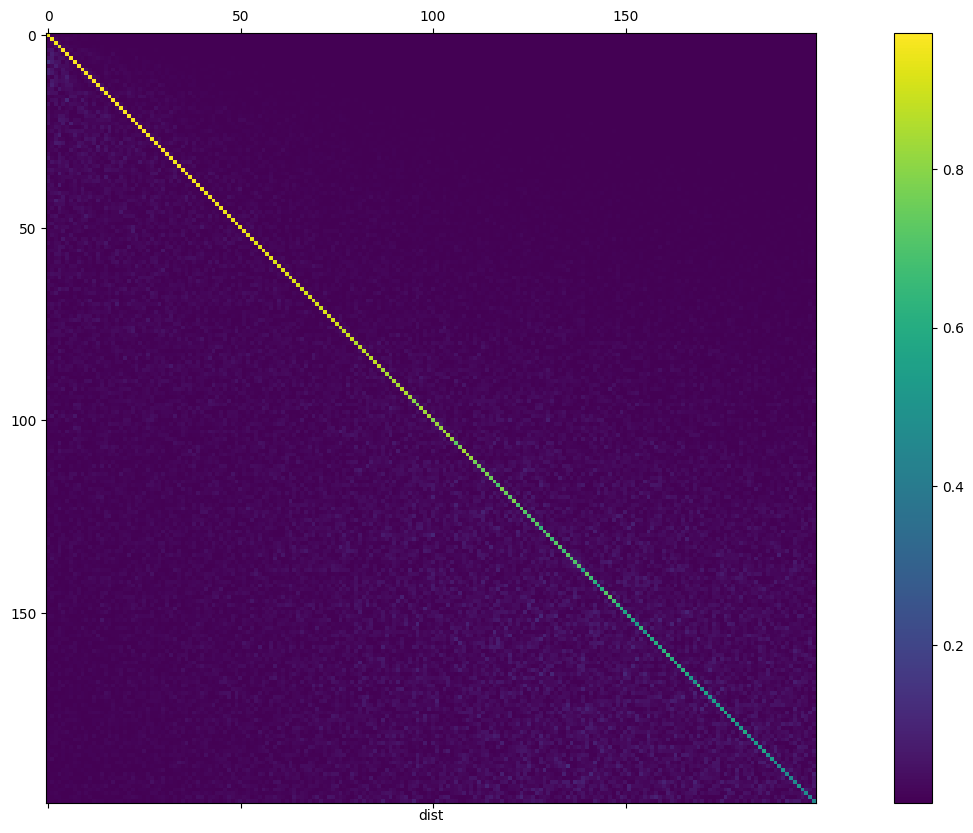

In [12]:
ax = plt.figure(figsize=(20,10)).gca()
cf = np.corrcoef(indiv_comps.T, sem_a.T)[:200,200:]
im = ax.matshow(np.absolute(cf)); plt.colorbar(im); plt.xlabel("dist");

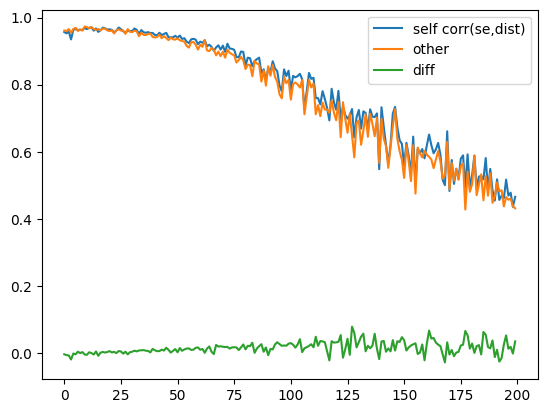

In [15]:
sem2 = semodes[full_subjs[10]]
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
sem2_a = alignment.fit([sem2], indiv_comps).aligned_[0]
cf2 = np.corrcoef(indiv_comps.T, sem2_a.T)[:200,200:]

plt.plot(np.diagonal(cf))
plt.plot(np.diagonal(cf2))
plt.plot(np.diagonal(cf)-np.diagonal(cf2))
plt.legend(["self corr(se,dist)", "other", "diff"])

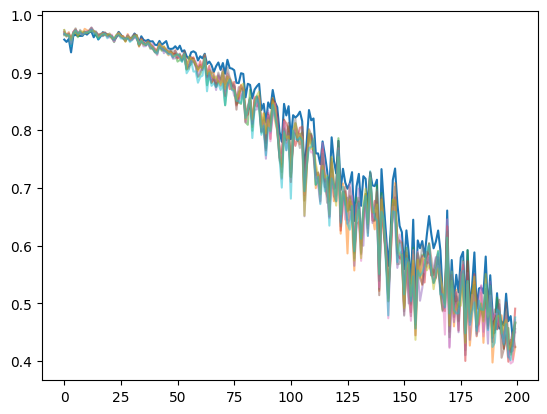

In [16]:
# look at how well SEmodes and distance align within and across subjects
semOthers = [semodes[full_subjs[sid]] for sid in [10,12,17,18,45, 100,110,175,199]]
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
sem2_a = alignment.fit(semOthers, indiv_comps).aligned_
diff = None

plt.plot(np.diagonal(cf))
for semo in sem2_a:
  cf2 = np.corrcoef(indiv_comps.T, semo.T)[:200,200:]
  plt.plot(np.diagonal(cf2), alpha =0.5)
  nd= np.diagonal(cf)-np.diagonal(cf2)
  diff = nd if diff is None else diff+nd

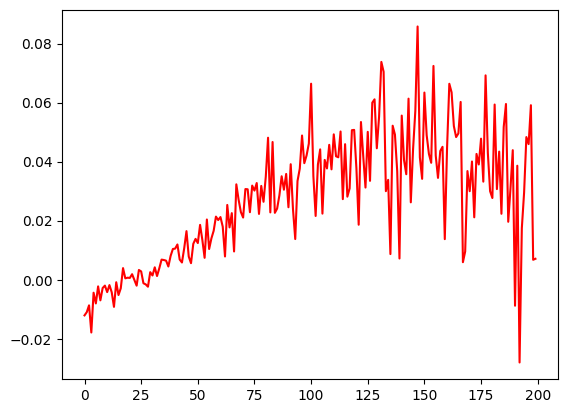

In [17]:
# quantify how much better we fit within than across subjects
# higher order components seem to be best aligning!
diff = diff/len(sem2_a)
plt.plot(diff, color="red")